In [1]:
import os, sys
from pathlib import Path

project_path = Path(os.getcwd())
sys.path.append(str(project_path) +'/')

data_path = project_path/'data'/'morphomnist'/'global'

In [2]:
import torch
from torch.utils.data import DataLoader,random_split
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
from mmnist import mmnist
from utils.helpers import EarlyStopper

In [3]:
from utils.datasets import MorphomnistDataset
from utils.visualize import grid_show
from torchvision import transforms 
from utils.customTransforms import ToFloatMNIST

batch_size = 64
dataset = MorphomnistDataset(data_path, transforms.Compose([ToFloatMNIST(),transforms.ToTensor()]), gz=True)

In [4]:
m =len(dataset)
train_data, val_data = random_split(dataset, [math.floor(m-m*0.2), math.ceil(m*0.2)], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

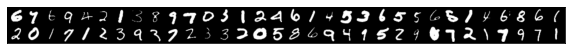

In [5]:
grid_show(next(iter(train_loader))[0])

## Train AE

In [6]:
encoded_dim = 32

model = mmnist(encoded_dim)
losses = {'mse_train_loss':[],'mse_val_loss':[],'nll_train_loss':[],'nll_val_loss':[]}

Selected device: cuda


In [7]:
early_stopper = EarlyStopper(patience=3, min_delta=0.00005)

for epoch in (pbar := tqdm(range(500))):
    mse_train_loss = model.train_ae(train_loader, lr=0.001)
    mse_val_loss = model.test_MSE(val_loader)
    
    losses['mse_train_loss'].append(mse_train_loss)    
    losses['mse_val_loss'].append(mse_val_loss)
    
    if early_stopper.early_stop(mse_val_loss):             
        break    
        
    pbar.set_description(f"mse_train: {mse_train_loss:.6f}, mse_val: {losses['mse_val_loss'][-1]:.6f}")

  0%|          | 0/500 [00:00<?, ?it/s]

(0.0, 0.05)

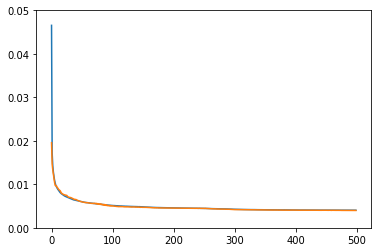

In [8]:
plt.plot(losses['mse_train_loss'])
plt.plot(losses['mse_val_loss'])
plt.ylim([0,0.05])

## Train Flow

In [9]:
early_stopper = EarlyStopper(patience=3, min_delta=0.1)

for epoch in (pbar := tqdm(range(300))):
    nll_train_loss = model.train_macaw(train_loader, lr=0.0001)
    nll_val_loss = model.test_likelihood(val_loader)
    
    losses['nll_train_loss'].append(nll_train_loss)
    losses['nll_val_loss'].append(nll_val_loss)
    
    if early_stopper.early_stop(nll_val_loss):             
        break
        
    pbar.set_description(f"nll_train: {nll_train_loss:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")

  0%|          | 0/300 [00:00<?, ?it/s]

In [10]:
with open(project_path/'models'/'MMNIST_model.pkl', 'wb') as f:
    pickle.dump({'model':model, 'losses':losses}, f)

## Counterfactulas

label 0
thickness 2
slant 0.3


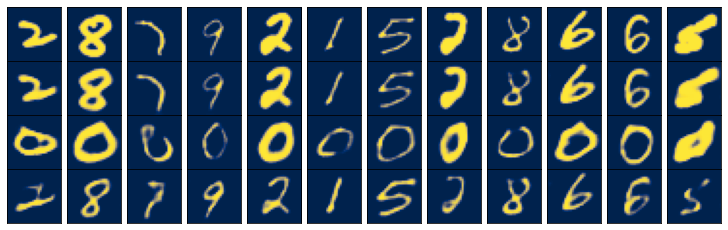

In [11]:
model.cf_test(val_loader)